In [1]:
import os
import sys
import time
# import glob
import numpy as np
import pandas as pd
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from sklearn import linear_model

%matplotlib tk

plt.ion()
plt.rcParams["image.cmap"] = "gist_gray"

### River Oaks Woods Chicago has no coordinates information, East River Park Chicago has no transect maps, Sag Quarries has no TIF pictures matches the IMD file. There are total 26 pictures. JUN 17 (6), SEP18(10), SEP29(10). So I will try fitting regression model using photos of Sep 18 and Sep 29. There are only 10 records for each day.

In [2]:
# images took at sep 18
dpath = "output/SEP18"
flist_SEP18 = [os.path.join(dpath, i) for i in 
         sorted(os.listdir(os.path.join(dpath)))]

for fname in flist_SEP18 :
    print(fname)

output/SEP18/Blue_Star_Memorial_Woods_17SEP18165731.png
output/SEP18/Chipilly_Woods_17SEP18165737.png
output/SEP18/Clayton_Smith_Woods_17SEP18165731.png
output/SEP18/Edgebrook_Woods_17SEP18165731.png
output/SEP18/Forest_Glen_Woods_17SEP18165731.png
output/SEP18/LaBagh_Woods_17SEP18165731.png
output/SEP18/Linne_Woods_17SEP18165731.png
output/SEP18/Skokie_Lagoons_17SEP18165737.png
output/SEP18/Somme_Woods_17SEP18165737.png
output/SEP18/Watersmeet_Woods_17SEP18165737.png


In [3]:
# images took at sep 29
dpath = "output/SEP29"
flist_SEP29 = [os.path.join(dpath, i) for i in 
         sorted(os.listdir(os.path.join(dpath)))]

for fname in flist_SEP29 :
    print(fname)

output/SEP29/Beaubien_Woods_17SEP29170130.png
output/SEP29/Blue_Star_Memorial_Woods_17SEP29170927.png
output/SEP29/Clayton_Smith_Woods_17SEP29170927.png
output/SEP29/Edgebrook_Woods_17SEP29170927.png
output/SEP29/Forest_Glen_Woods_17SEP29170927.png
output/SEP29/Kickapoo_Woods_17SEP29170931.png
output/SEP29/LaBagh_Woods_17SEP29170927.png
output/SEP29/Ronan_Park_17SEP29170928.png
output/SEP29/Wampum_Lake_17SEP29170932.png
output/SEP29/Whistler_Woods_17SEP29170931.png


In [4]:
imgs_SEP18 = np.array([nd.imread(i)[:, :, :] for i in flist_SEP18])
imgs_SEP29 = np.array([nd.imread(i)[:, :, :] for i in flist_SEP29])

In [5]:
stamp_SEP18 = np.zeros_like(imgs_SEP18)
for i in range(10):
    prow = [5, imgs_SEP18[i].shape[0]-5]
    pcol = [5, imgs_SEP18[i].shape[1]-5]
    stamp_SEP18[i] = imgs_SEP18[i][prow[0]:prow[1], pcol[0]:pcol[1]]

In [6]:
stamp_SEP29 = np.zeros_like(imgs_SEP29)
for i in range(10):
    prow = [5, imgs_SEP29[i].shape[0]-5]
    pcol = [5, imgs_SEP29[i].shape[1]-5]
    stamp_SEP29[i] = imgs_SEP29[i][prow[0]:prow[1], pcol[0]:pcol[1]]

In [7]:
# FQI information of July-Sep
df =  pd.read_csv('regression.csv')
df.index = df['July-Sept.'].apply(lambda x: x.split(" ")[0])
df.head()

,July-Sept.,(% Native coverage),(Mean C - Native),(wC),(FQI - Native),Species Richness,% Native species,% Native coverage,Mean C (Native),Mean C (All Species),wC,FQI (Native),FQI (All Species),FQI (Adjusted)
July-Sept.,,,,,,,,,,,,,,
Somme,Somme Woods,2.0,1.0,1.0,1.0,62,79,83,4.33,3.42,3.61,30.29,26.92,38.46
Chipilly,Chipilly Woods (A&B),6.0,2.0,2.0,2.0,56,80,71,4.29,3.45,3.33,28.77,25.79,38.45
Forest,Forest Glen Woods,3.0,3.0,3.0,3.0,43,79,76,4.18,3.30,3.13,24.35,21.65,37.14
Beaubien,Beaubien Woods,13.0,9.0,12.0,4.0,66,70,63,3.41,2.38,1.90,23.15,19.33,28.49
Watersmeet,Watersmeet Woods,8.0,4.0,8.0,5.0,37,84,69,3.87,3.24,2.33,21.55,19.73,35.43


##  Regression (Sep 18)

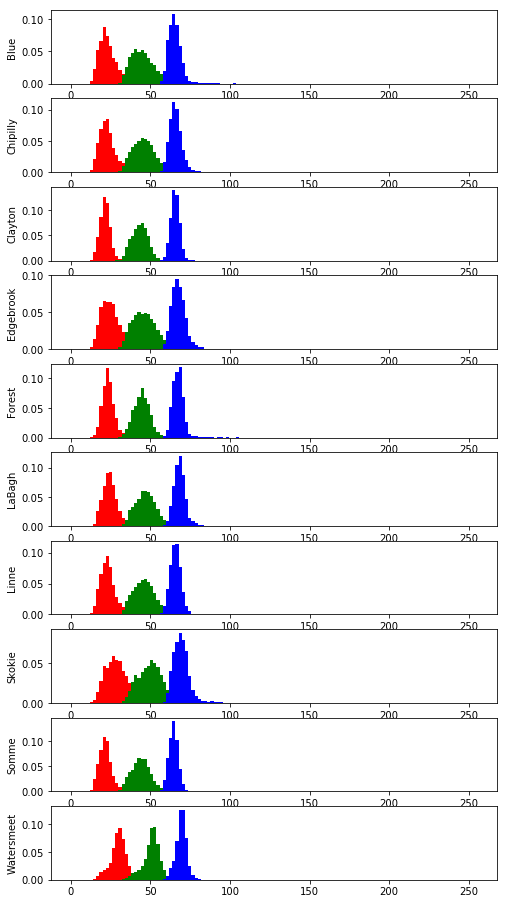

In [8]:
# plot hist uisng three channel
clrs = ["red", "green", "blue"]
fig1, ax1 = plt.subplots(10, 1, num=1, figsize=[8,16])
col_SEP18 = np.zeros((10,9), dtype=float)
for j in range(10):
    [ax1[j].hist(stamp_SEP18[j][:, :, i].flatten(), bins=128, range=[0, 255], 
               normed=True, color=clrs[i]) for i in range(3)]
    ax1[j].set_ylabel(flist_SEP18[j].split("/")[2].split("_")[0])
    for i in range(3):
        col_SEP18[j,i] = np.mean(stamp_SEP18[j][:, :, i].flatten())
        col_SEP18[j,i+3] = np.std(stamp_SEP18[j][:, :, i].flatten())        
        col_SEP18[j,6] = df.loc[flist_SEP18[j].split("/")[2].split("_")[0],'FQI (Native)']
        col_SEP18[j,7] = df.loc[flist_SEP18[j].split("/")[2].split("_")[0],'FQI (All Species)']
        col_SEP18[j,8] = df.loc[flist_SEP18[j].split("/")[2].split("_")[0],'FQI (Adjusted)']
fig1.canvas.draw()

In [9]:
df_sep18 = pd.DataFrame(col_SEP18, columns=['mean0', 'mean1', 'mean2', 'std0', 'std1', 'std2', 'FQI_Native', 'FQI_All', 'FQI_Adjusted'])
df_sep18.head()

,mean0,mean1,mean2,std0,std1,std2,FQI_Native,FQI_All,FQI_Adjusted
0,23.322745,45.182153,65.278805,6.942290,7.862846,4.755740,21.04,17.58,28.90
1,23.141911,45.514399,65.588171,6.195131,7.008605,3.912323,28.77,25.79,38.45
2,21.158074,43.013856,65.322342,3.363729,5.070710,2.766446,15.69,12.06,23.65
3,24.661306,45.541085,67.462230,6.243945,7.170776,4.348496,17.33,15.17,25.28
4,23.683464,44.448338,67.316141,5.440178,5.717194,3.912048,24.35,21.65,37.14


In [10]:
# use mean and std to predict FQI (Native)
result = smf.ols(formula = 'FQI_Native ~ '+ '+'.join(df_sep18.columns[:-3]), data = df_sep18).fit()
result.summary()

/opt/rh/anaconda/root/lib/python2.7/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FQI_Native   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                 -0.827
Method:                 Least Squares   F-statistic:                    0.3208
Date:                Fri, 18 May 2018   Prob (F-statistic):              0.890
Time:                        11:11:16   Log-Likelihood:                -27.049
No. Observations:                  10   AIC:                             68.10
Df Residuals:                       3   BIC:                             70.22
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.5621    249.110     -0.095      0.931    -816.341     769.216
mean0         -2.5271      6.098     -0.414      0.706     -21.933      16.879
mean1          0.9678      6.751      0.143      0.895     -20.516      22.451
mean2          1.0852      5.033      0.216      0.843     -14.934      17.104
std0          10.8344     11.209      0.967      0.405     -24.839      46.507
std1          -2.7385     10.855     -0.252      0.817     -37.283      31.806
std2         -13.7234     24.269     -0.565      0.611     -90.959      63.512
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   2.292
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.197
Skew:                          -0.280   Prob(JB):                        0.906
Kurtosis:                       2.601   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The p values for all features are larger than 0.05. No significant coefficients.

In [11]:
# use mean and std to predict FQI (All Species)
result = smf.ols(formula = 'FQI_All ~ '+ '+'.join(df_sep18.columns[:-3]), data = df_sep18).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                FQI_All   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                 -0.783
Method:                 Least Squares   F-statistic:                    0.3414
Date:                Fri, 18 May 2018   Prob (F-statistic):              0.878
Time:                        11:11:16   Log-Likelihood:                -27.438
No. Observations:                  10   AIC:                             68.88
Df Residuals:                       3   BIC:                             70.99
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -57.4520    258.992     -0.222      0.839    -881.680     766.776
mean0         -2.9030      6.340     -0.458      0.678     -23.079      17.273
mean1          0.8784      7.018      0.125      0.908     -21.457      23.214
mean2          1.7993      5.233      0.344      0.754     -14.855      18.454
std0          12.3452     11.654      1.059      0.367     -24.743      49.433
std1          -3.3404     11.285     -0.296      0.787     -39.256      32.575
std2         -15.8299     25.232     -0.627      0.575     -96.129      64.469
==============================================================================
Omnibus:                        0.653   Durbin-Watson:                   2.300
Prob(Omnibus):                  0.722   Jarque-Bera (JB):                0.326
Skew:                          -0.395   Prob(JB):                        0.850
Kurtosis:                       2.602   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The p values for all features are larger than 0.05. No significant coefficients.

In [12]:
# use mean and std to predict FQI (Adjusted)
result = smf.ols(formula = 'FQI_Adjusted ~ '+ '+'.join(df_sep18.columns[:-3]), data = df_sep18).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FQI_Adjusted   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                 -0.729
Method:                 Least Squares   F-statistic:                    0.3675
Date:                Fri, 18 May 2018   Prob (F-statistic):              0.863
Time:                        11:11:16   Log-Likelihood:                -28.794
No. Observations:                  10   AIC:                             71.59
Df Residuals:                       3   BIC:                             73.71
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.8736    296.601     -0.188      0.863    -999.791     888.044
mean0         -3.6822      7.260     -0.507      0.647     -26.788      19.424
mean1          2.2038      8.038      0.274      0.802     -23.375      27.783
mean2          1.4652      5.993      0.244      0.823     -17.607      20.538
std0          13.5235     13.346      1.013      0.386     -28.950      55.997
std1          -8.1486     12.924     -0.630      0.573     -49.279      32.982
std2         -11.6371     28.896     -0.403      0.714    -103.597      80.323
==============================================================================
Omnibus:                        0.914   Durbin-Watson:                   2.331
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.351
Skew:                          -0.438   Prob(JB):                        0.839
Kurtosis:                       2.726   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The p values for all features are larger than 0.05. No significant coefficients.

##  Regression (Sep 29)

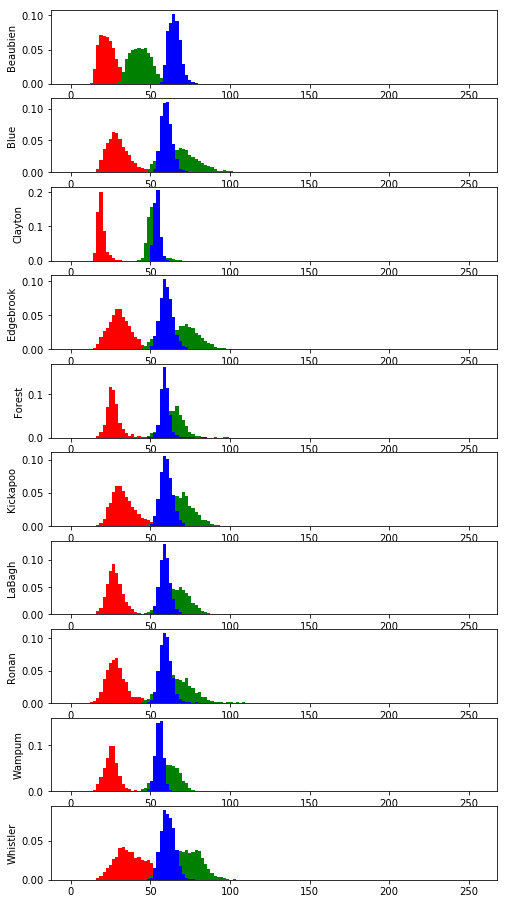

In [13]:
# plot hist uisng three channel
clrs = ["red", "green", "blue"]
fig1, ax1 = plt.subplots(10, 1, num=1, figsize=[8,16])
col_SEP29 = np.zeros((10,9), dtype=float)
for j in range(10):
    [ax1[j].hist(stamp_SEP29[j][:, :, i].flatten(), bins=128, range=[0, 255], 
               normed=True, color=clrs[i]) for i in range(3)]
    ax1[j].set_ylabel(flist_SEP29[j].split("/")[2].split("_")[0])
    for i in range(3):
        col_SEP29[j,i] = np.mean(stamp_SEP29[j][:, :, i].flatten())
        col_SEP29[j,i+3] = np.std(stamp_SEP29[j][:, :, i].flatten())
        col_SEP29[j,6] = df.loc[flist_SEP29[j].split("/")[2].split("_")[0],'FQI (Native)']
        col_SEP29[j,7] = df.loc[flist_SEP29[j].split("/")[2].split("_")[0],'FQI (All Species)']
        col_SEP29[j,8] = df.loc[flist_SEP29[j].split("/")[2].split("_")[0],'FQI (Adjusted)']
fig1.canvas.draw()

In [14]:
df_sep29 = pd.DataFrame(col_SEP29, columns=['mean0', 'mean1', 'mean2', 'std0', 'std1', 'std2', 'FQI_Native', 'FQI_All', 'FQI_Adjusted'])
df_sep29.head()

,mean0,mean1,mean2,std0,std1,std2,FQI_Native,FQI_All,FQI_Adjusted
0,23.033028,43.617579,64.787975,5.533569,6.506419,3.648411,23.15,19.33,28.49
1,29.628717,68.518338,60.125245,7.988845,10.872545,3.870428,21.04,17.58,28.90
2,18.674829,51.060241,53.876874,2.384283,4.058706,1.831996,15.69,12.06,23.65
3,30.510791,68.303108,59.950504,7.626092,10.638611,4.185136,17.33,15.17,25.28
4,26.434003,64.250843,58.885255,4.788213,6.433801,2.940717,24.35,21.65,37.14


In [15]:
result = smf.ols(formula = 'FQI_Native ~ '+ '+'.join(df_sep29.columns[:-3]), data = df_sep29).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FQI_Native   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     9.843
Date:                Fri, 18 May 2018   Prob (F-statistic):             0.0439
Time:                        11:11:38   Log-Likelihood:                -9.7556
No. Observations:                  10   AIC:                             33.51
Df Residuals:                       3   BIC:                             35.63
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -129.4834     23.363     -5.542      0.012    -203.833     -55.133
mean0         -0.4909      0.521     -0.942      0.415      -2.149       1.167
mean1          0.5271      0.208      2.538      0.085      -0.134       1.188
mean2          2.6658      0.421      6.328      0.008       1.325       4.007
std0           0.4050      1.181      0.343      0.754      -3.355       4.165
std1           0.5539      0.832      0.666      0.553      -2.095       3.202
std2         -10.3307      2.900     -3.563      0.038     -19.559      -1.102
==============================================================================
Omnibus:                        1.160   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.560   Jarque-Bera (JB):                0.741
Skew:                          -0.603   Prob(JB):                        0.690
Kurtosis:                       2.429   Cond. No.                     5.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### mean2 and std2 (blue) are significant coefficients. Too few records, have the problem of overfitting.

In [16]:
result = smf.ols(formula = 'FQI_All ~ '+ '+'.join(df_sep29.columns[:-3]), data = df_sep29).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                FQI_All   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     10.16
Date:                Fri, 18 May 2018   Prob (F-statistic):             0.0420
Time:                        11:11:38   Log-Likelihood:                -10.104
No. Observations:                  10   AIC:                             34.21
Df Residuals:                       3   BIC:                             36.33
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -135.6981     24.191     -5.609      0.011    -212.684     -58.712
mean0         -0.0633      0.539     -0.117      0.914      -1.780       1.653
mean1          0.4651      0.215      2.162      0.119      -0.219       1.150
mean2          2.6246      0.436      6.017      0.009       1.236       4.013
std0          -1.0082      1.223     -0.824      0.470      -4.901       2.885
std1           1.0394      0.862      1.206      0.314      -1.703       3.782
std2          -9.6146      3.003     -3.202      0.049     -19.170      -0.059
==============================================================================
Omnibus:                        0.623   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.464
Skew:                          -0.438   Prob(JB):                        0.793
Kurtosis:                       2.410   Cond. No.                     5.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### mean2 and std2 (blue) are significant coefficients. Too few records, have the problem of overfitting.

In [17]:
result = smf.ols(formula = 'FQI_Adjusted ~ '+ '+'.join(df_sep29.columns[:-3]), data = df_sep29).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FQI_Adjusted   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     2.244
Date:                Fri, 18 May 2018   Prob (F-statistic):              0.271
Time:                        11:11:38   Log-Likelihood:                -18.715
No. Observations:                  10   AIC:                             51.43
Df Residuals:                       3   BIC:                             53.55
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -152.3236     57.229     -2.662      0.076    -334.451      29.804
mean0         -1.3157      1.276     -1.031      0.378      -5.376       2.745
mean1          1.1565      0.509      2.273      0.108      -0.463       2.776
mean2          2.9951      1.032      2.902      0.062      -0.289       6.279
std0           1.5527      2.894      0.537      0.629      -7.658      10.763
std1          -1.2928      2.039     -0.634      0.571      -7.781       5.195
std2          -9.2664      7.103     -1.305      0.283     -31.872      13.339
==============================================================================
Omnibus:                        0.833   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.702
Skew:                          -0.494   Prob(JB):                        0.704
Kurtosis:                       2.159   Cond. No.                     5.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The p values for all features are larger than 0.05. No significant coefficients. Too few records, have the problem of overfitting.

### Show overfitting problem

In [18]:
from sklearn.cross_validation import train_test_split

/opt/rh/anaconda/root/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
train, test  = train_test_split(df_sep29, test_size = 0.2, random_state=999)
X_train = train.loc[:,"mean0":"std2"]
y_train = train['FQI_Native']
X_test = test.loc[:,"mean0":"std2"]
y_test = test['FQI_Native']
lm1 = smf.ols(formula = 'FQI_Native ~ '+ '+'.join(train.columns[:-3]), data = train).fit()
linear = linear_model.LinearRegression().fit(X_train, y_train)
print ("R squared value is {}\n\nP value are\n{}\n\ncoefficient are\n{}".format(lm1.rsquared, lm1.pvalues, lm1.params))
print ("regression score of linear regression in-sample %.2f, out-sample %.2f"%(
linear.score(X_train, y_train), linear.score(X_test, y_test)))

R squared value is 0.964463374664

P value are
Intercept    0.342753
mean0        0.566104
mean1        0.310510
mean2        0.250922
std0         0.757507
std1         0.912726
std2         0.346801
dtype: float64

coefficient are
Intercept   -94.962591
mean0        -0.856677
mean1         0.547127
mean2         2.136272
std0          1.107505
std1         -0.238666
std2         -7.947389
dtype: float64
regression score of linear regression in-sample 0.96, out-sample 0.16
